In [42]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from utils import *
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

%matplotlib inline
cwd = os.getcwd()
input_dir = os.path.join(os.path.dirname(cwd), 'data', 'for_bb')
TARGET_WIDTH = 300
TARGET_HEIGHT = 268
img_shape=(3, TARGET_HEIGHT, TARGET_WIDTH)
target_size = (TARGET_HEIGHT,TARGET_WIDTH)

In [16]:
% cd $cwd

/home/ubuntu/courses/deeplearning1/nbs/whale_recognition


# Setup

In [17]:
ann = pd.read_csv('bbox_300_268_.csv')

In [18]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/for_bb'

In [45]:
tr_b = ImageDataGenerator().flow_from_directory(input_dir+'/train',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 3862 images belonging to 1 classes.


In [46]:
val_b = ImageDataGenerator().flow_from_directory(input_dir+'/valid',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 682 images belonging to 1 classes.


In [47]:
tr_files = tr_b.filenames

In [48]:
val_files = val_b.filenames

In [49]:
tr_data = np.concatenate([tr_b.next() for i in range(tr_b.nb_sample)])

In [50]:
tr_data.shape

(3862, 3, 268, 300)

In [51]:
val_data = np.concatenate([val_b.next() for i in range(val_b.nb_sample)])

In [52]:
val_data.shape

(682, 3, 268, 300)

In [55]:
tr_files= [f[f.find('/')+1:] for f in tr_b.filenames]

In [56]:
val_files = [f[f.find('/')+1:] for f in val_b.filenames]

In [57]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [58]:
val_ann = ann[ann.Image.isin(val_files)]

In [59]:
val_ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,116.417902,133.275580,61.417318,62.645665
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,146.162877,128.821597,32.967337,46.647629
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,137.402326,84.336441,42.880592,70.434830
7,w_825.jpg,whale_33152,545.330467,590.184488,3504,2336,1534.479668,864.030090,w_825.jpg,2033.228315,966.540379,1707.166500,1108.610169,131.376684,99.126740,50.529494,62.563598
11,w_3909.jpg,whale_06069,460.343900,632.677771,3072,2048,1397.556867,887.637469,w_3909.jpg,1925.487537,1157.742772,1678.420738,1031.146560,136.480163,116.155684,61.784939,60.240315


In [60]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    w = r.width_new.values[0]
    h = r.height_new.values[0]
    x = r.bboxx_new.values[0]
    y = r.bboxy_new.values[0]
    tr_y.append([w,h,x,y])

val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    w = r.width_new.values[0]
    h = r.height_new.values[0]
    x = r.bboxx_new.values[0]
    y = r.bboxy_new.values[0]
    val_y.append([w,h,x,y])

tr_y = np.array(tr_y)

val_y = np.array(val_y)

In [67]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[0], bb[1], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_y[i]
    plot(val_data[i])
    plt.gca().add_patch(create_rect(bb))

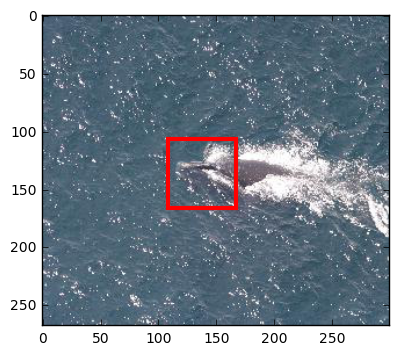

In [71]:
show_bb(14)

In [32]:
def check_smaller(names, bboxes, sub_dir):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    bbox = bboxes[idx,:]    
    
    f_name =os.path.join(input_dir, sub_dir, f)
    img = Image.open(f_name)
    img_arr = np.array(img, dtype=np.uint8)
    print(img_arr.shape)
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
    rect = patches.Rectangle((bbox[2],bbox[3] ),
                             bbox[0],
                             bbox[1], 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    print(f)
    plt.show()



1895
(268, 300, 3)
w_3376.jpg


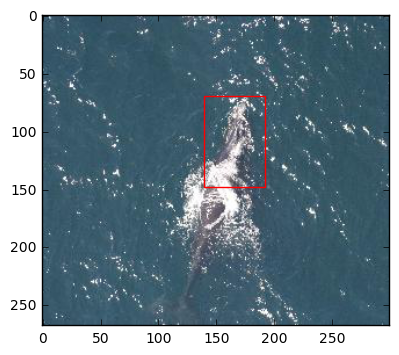

In [35]:
check_smaller(tr_files, tr_y, 'train/wrap')

210
(268, 300, 3)
w_7777.jpg


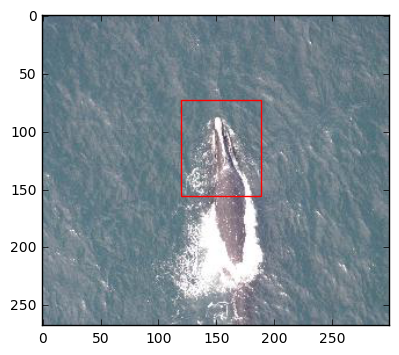

In [41]:
check_smaller(val_files, val_y, 'valid/wrap')

# Fit Model

In [17]:
tr_mean = np.mean(tr_data, axis=(0,2,3))

NameError: name 'tr_data' is not defined

In [19]:
tr_mean.shape

(3,)

In [20]:
tr_mean.reshape((3,1,1))

array([[[  71.9883]],

       [[  95.0805]],

       [[ 108.2789]]])

In [28]:
tr_mean_r = tr_mean.reshape((3,1,1))

In [ ]:
tr_mean = np.array([71])

In [21]:
def std(x): 
    x = x-tr_mean.reshape((3,1,1))
    return x

In [22]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=img_shape),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [23]:
model = get_model()

In [57]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [58]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 654s - loss: 993.9016 - acc: 0.6512 - val_loss: 1154.5772 - val_acc: 0.7405
Epoch 2/25
3862/3862 [==============================] - 654s - loss: 479.1319 - acc: 0.7543 - val_loss: 540.7527 - val_acc: 0.7903
Epoch 3/25
3862/3862 [==============================] - 654s - loss: 395.0816 - acc: 0.7913 - val_loss: 421.7732 - val_acc: 0.7903
Epoch 4/25
3862/3862 [==============================] - 654s - loss: 364.9412 - acc: 0.7965 - val_loss: 481.3452 - val_acc: 0.7258
Epoch 5/25
3862/3862 [==============================] - 654s - loss: 327.1424 - acc: 0.7947 - val_loss: 313.1418 - val_acc: 0.8006
Epoch 6/25


KeyboardInterrupt: 

In [59]:
model.save_weights('bb_reg_3.13.h5')

In [32]:
model.load_weights('bb_reg_3.13.h5')

In [33]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [34]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=3)

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 666s - loss: 359.5486 - acc: 0.8030 - val_loss: 360.4858 - val_acc: 0.8299
Epoch 2/3
3862/3862 [==============================] - 668s - loss: 287.5727 - acc: 0.8322 - val_loss: 366.1349 - val_acc: 0.8182
Epoch 3/3
3862/3862 [==============================] - 667s - loss: 261.4464 - acc: 0.8392 - val_loss: 807.6691 - val_acc: 0.7331


In [35]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=2)

Train on 3862 samples, validate on 682 samples
Epoch 1/2
3862/3862 [==============================] - 666s - loss: 250.0704 - acc: 0.8537 - val_loss: 283.1299 - val_acc: 0.8358
Epoch 2/2
3862/3862 [==============================] - 669s - loss: 206.9150 - acc: 0.8685 - val_loss: 287.2034 - val_acc: 0.8431


In [36]:
model.save_weights('bb_reg_2.87.h5')

In [37]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=2)

Train on 3862 samples, validate on 682 samples
Epoch 1/2
3862/3862 [==============================] - 668s - loss: 194.9291 - acc: 0.8734 - val_loss: 311.1483 - val_acc: 0.8328
Epoch 2/2
3862/3862 [==============================] - 671s - loss: 173.0131 - acc: 0.8840 - val_loss: 293.6020 - val_acc: 0.8167


In [38]:
model.optimizer.lr = 0.0001

In [39]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=2)

Train on 3862 samples, validate on 682 samples
Epoch 1/2
3862/3862 [==============================] - 672s - loss: 146.9179 - acc: 0.8956 - val_loss: 295.8965 - val_acc: 0.8358
Epoch 2/2
3862/3862 [==============================] - 675s - loss: 129.3878 - acc: 0.8988 - val_loss: 287.8410 - val_acc: 0.8534


In [40]:
model.save_weights('bb_reg_287_better_acc.h5')

In [24]:
model.load_weights('bb_reg_287_better_acc.h5')

In [25]:
model.compile(Adam(lr=0.0001), loss='mean_squared_error', metrics=['accuracy'])

In [26]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 3862 samples, validate on 682 samples
Epoch 1/10
3862/3862 [==============================] - 671s - loss: 89.8805 - acc: 0.9208 - val_loss: 244.4062 - val_acc: 0.8798
Epoch 2/10
3862/3862 [==============================] - 673s - loss: 77.1726 - acc: 0.9285 - val_loss: 242.3324 - val_acc: 0.8695
Epoch 3/10
3862/3862 [==============================] - 673s - loss: 74.5225 - acc: 0.9247 - val_loss: 239.4554 - val_acc: 0.8827
Epoch 4/10
3862/3862 [==============================] - 673s - loss: 68.0242 - acc: 0.9259 - val_loss: 244.7937 - val_acc: 0.8768
Epoch 5/10
3862/3862 [==============================] - 673s - loss: 65.3615 - acc: 0.9270 - val_loss: 248.3265 - val_acc: 0.8783
Epoch 6/10
3862/3862 [==============================] - 673s - loss: 61.4059 - acc: 0.9353 - val_loss: 241.5686 - val_acc: 0.8754
Epoch 7/10
1760/3862 [============>.................] - ETA: 349s - loss: 58.5226 - acc: 0.9324

KeyboardInterrupt: 

In [28]:
model.save_weights('241.h5')

# Vgg Model

In [78]:
del tr_data
del val_data

In [73]:
import vgg16bn

In [74]:
vgg = Vgg16BN(size=target_size, include_top=False)

In [75]:
model = vgg.model

In [81]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 268, 300)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 270, 302)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 268, 300)  0           zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 270, 302)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [78]:
for l  in model.layers: l.trainable = False

In [79]:
tr_conv_f = model.predict(tr_data)

In [80]:
tr_conv_f.shape

(3862, 512, 8, 9)

In [82]:
save_array('vggbb_300_268_conv_feat.bc', tr_conv_f)

In [84]:
val_conv_f = model.predict(val_data)

In [85]:
val_conv_f.shape

(682, 512, 8, 9)

In [86]:
save_array('vggbb_300_268_conv_feat_val.bc', val_conv_f)

In [87]:
tr_f = load_array('vggbb_300_268_conv_feat.bc')

In [89]:
val_f = load_array('vggbb_300_268_conv_feat_val.bc')

In [161]:
def get_lm():
    return Sequential([
            Flatten(input_shape=(512,8,9)),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(4, activation='linear')
        ])

In [162]:
lm = get_lm()

In [163]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [164]:
lm.fit(tr_conv_f, tr_y, validation_data=(val_conv_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 4s - loss: 8161.7840 - acc: 0.5339 - val_loss: 7295.2726 - val_acc: 0.5543
Epoch 2/25
3862/3862 [==============================] - 4s - loss: 4954.8364 - acc: 0.6422 - val_loss: 2498.1705 - val_acc: 0.6862
Epoch 3/25
3862/3862 [==============================] - 4s - loss: 1041.1379 - acc: 0.7960 - val_loss: 326.6589 - val_acc: 0.8563
Epoch 4/25
3862/3862 [==============================] - 4s - loss: 251.4850 - acc: 0.8698 - val_loss: 192.9233 - val_acc: 0.8886
Epoch 5/25
3862/3862 [==============================] - 4s - loss: 203.4533 - acc: 0.8884 - val_loss: 196.0169 - val_acc: 0.8856
Epoch 6/25
3862/3862 [==============================] - 4s - loss: 188.1754 - acc: 0.8832 - val_loss: 196.2684 - val_acc: 0.8959
Epoch 7/25
3862/3862 [==============================] - 4s - loss: 178.7240 - acc: 0.8920 - val_loss: 189.4760 - val_acc: 0.8974
Epoch 8/25
3862/3862 [=======================

KeyboardInterrupt: 

In [156]:
lm.optimizer.lr = 0.0001

In [157]:
lm.fit(tr_conv_f, tr_y, validation_data=(val_conv_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 2s - loss: 304.1464 - acc: 0.8566 - val_loss: 186.0179 - val_acc: 0.9018
Epoch 2/25
3862/3862 [==============================] - 2s - loss: 298.5472 - acc: 0.8555 - val_loss: 185.1092 - val_acc: 0.8959
Epoch 3/25
3862/3862 [==============================] - 2s - loss: 292.1844 - acc: 0.8610 - val_loss: 189.5537 - val_acc: 0.8871
Epoch 4/25
3862/3862 [==============================] - 2s - loss: 293.2685 - acc: 0.8524 - val_loss: 183.0011 - val_acc: 0.9032
Epoch 5/25
3862/3862 [==============================] - 2s - loss: 295.3116 - acc: 0.8622 - val_loss: 185.5322 - val_acc: 0.9032
Epoch 6/25
3862/3862 [==============================] - 2s - loss: 273.4506 - acc: 0.8472 - val_loss: 184.6233 - val_acc: 0.8959
Epoch 7/25
3862/3862 [==============================] - 2s - loss: 274.7693 - acc: 0.8573 - val_loss: 181.9463 - val_acc: 0.8974
Epoch 8/25
3862/3862 [============================

In [159]:
lm.optimizer.lr = 0.00001

In [160]:
lm.fit(tr_conv_f, tr_y, validation_data=(val_conv_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 2s - loss: 245.1637 - acc: 0.8560 - val_loss: 175.9138 - val_acc: 0.8974
Epoch 2/25
3862/3862 [==============================] - 2s - loss: 239.8973 - acc: 0.8563 - val_loss: 175.6625 - val_acc: 0.8915
Epoch 3/25
3862/3862 [==============================] - 2s - loss: 240.2136 - acc: 0.8664 - val_loss: 177.7132 - val_acc: 0.8959
Epoch 4/25
3862/3862 [==============================] - 2s - loss: 242.7811 - acc: 0.8578 - val_loss: 172.8447 - val_acc: 0.9032
Epoch 5/25
3862/3862 [==============================] - 2s - loss: 230.7219 - acc: 0.8690 - val_loss: 173.5156 - val_acc: 0.9003
Epoch 6/25
3862/3862 [==============================] - 2s - loss: 234.1469 - acc: 0.8659 - val_loss: 177.1958 - val_acc: 0.8871
Epoch 7/25
3862/3862 [==============================] - 2s - loss: 228.2056 - acc: 0.8651 - val_loss: 174.2303 - val_acc: 0.8974
Epoch 8/25
3862/3862 [============================

KeyboardInterrupt: 

In [104]:
val_preds = lm.predict(val_conv_f)

25
(268, 300, 3)
w_1934.jpg


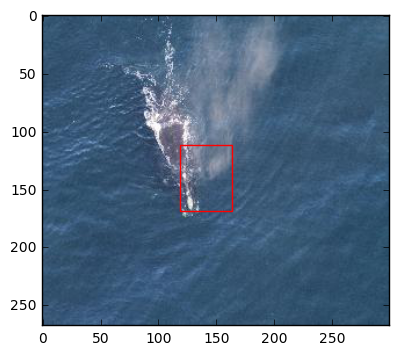

In [150]:
check_smaller(val_files[100:150], val_preds, 'valid/wrap')

In [42]:
lm.compile(Adam(lr=0.0001), loss='mean_squared_error', metrics=['accuracy'])

In [43]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=4)

Train on 3862 samples, validate on 682 samples
Epoch 1/4
3862/3862 [==============================] - 18s - loss: 46.6131 - acc: 0.9272 - val_loss: 161.8023 - val_acc: 0.8842
Epoch 2/4
3862/3862 [==============================] - 18s - loss: 43.2279 - acc: 0.9223 - val_loss: 161.7440 - val_acc: 0.8812
Epoch 3/4
3862/3862 [==============================] - 18s - loss: 44.9965 - acc: 0.9322 - val_loss: 161.6788 - val_acc: 0.8812
Epoch 4/4
1408/3862 [=========>....................] - ETA: 11s - loss: 45.6435 - acc: 0.9212

KeyboardInterrupt: 

In [44]:
lm.compile(Adam(lr=0.00001), loss='mean_squared_error', metrics=['accuracy'])

In [45]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=4)

Train on 3862 samples, validate on 682 samples
Epoch 1/4
3862/3862 [==============================] - 18s - loss: 43.4981 - acc: 0.9200 - val_loss: 161.4803 - val_acc: 0.8812
Epoch 2/4
3862/3862 [==============================] - 18s - loss: 42.3014 - acc: 0.9241 - val_loss: 161.6078 - val_acc: 0.8812
Epoch 3/4
3862/3862 [==============================] - 18s - loss: 43.3902 - acc: 0.9205 - val_loss: 161.7834 - val_acc: 0.8798
Epoch 4/4
3862/3862 [==============================] - 18s - loss: 44.2234 - acc: 0.9231 - val_loss: 161.6057 - val_acc: 0.8812


In [46]:
model.save_weights('bb_reg_161.h5')

In [47]:
def get_lm():
    return Sequential([
            Flatten(input_shape=(512,9,8)),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(4, activation='linear')
        ])

In [48]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [49]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 18s - loss: 44.9957 - acc: 0.9259 - val_loss: 163.2192 - val_acc: 0.8783
Epoch 2/25
3862/3862 [==============================] - 18s - loss: 43.5715 - acc: 0.9247 - val_loss: 165.4497 - val_acc: 0.8768
Epoch 3/25
3862/3862 [==============================] - 18s - loss: 42.5046 - acc: 0.9254 - val_loss: 163.4629 - val_acc: 0.8812
Epoch 4/25
3862/3862 [==============================] - 18s - loss: 43.5418 - acc: 0.9177 - val_loss: 164.7558 - val_acc: 0.8812
Epoch 5/25
3862/3862 [==============================] - 18s - loss: 44.9695 - acc: 0.9231 - val_loss: 162.1636 - val_acc: 0.8827
Epoch 6/25
3862/3862 [==============================] - 18s - loss: 42.3664 - acc: 0.9210 - val_loss: 163.0783 - val_acc: 0.8739
Epoch 7/25
3862/3862 [==============================] - 18s - loss: 39.7737 - acc: 0.9335 - val_loss: 160.5541 - val_acc: 0.8812
Epoch 8/25
3862/3862 [============================

KeyboardInterrupt: 

In [50]:
def get_lm():
    return Sequential([
            Flatten(input_shape=(512,9,8)),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.9),
            Dense(4, activation='linear')
        ])

In [51]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [52]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 18s - loss: 39.3906 - acc: 0.9272 - val_loss: 163.0510 - val_acc: 0.8798
Epoch 2/25
3862/3862 [==============================] - 18s - loss: 39.7375 - acc: 0.9239 - val_loss: 163.4361 - val_acc: 0.8768
Epoch 3/25
3862/3862 [==============================] - 18s - loss: 37.5030 - acc: 0.9303 - val_loss: 161.9034 - val_acc: 0.8783
Epoch 4/25
3862/3862 [==============================] - 18s - loss: 40.8683 - acc: 0.9210 - val_loss: 162.6386 - val_acc: 0.8754
Epoch 5/25
3862/3862 [==============================] - 18s - loss: 38.3925 - acc: 0.9252 - val_loss: 162.0769 - val_acc: 0.8827
Epoch 6/25
3862/3862 [==============================] - 18s - loss: 37.6744 - acc: 0.9210 - val_loss: 163.1065 - val_acc: 0.8812
Epoch 7/25
3862/3862 [==============================] - 18s - loss: 37.8789 - acc: 0.9213 - val_loss: 161.9744 - val_acc: 0.8812
Epoch 8/25
3862/3862 [============================

KeyboardInterrupt: 

In [53]:
def get_lm():
    return Sequential([
            Flatten(input_shape=(512,9,8)),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.8),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.8),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.8),
            Dense(4, activation='linear')
        ])

In [54]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [55]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 18s - loss: 38.4387 - acc: 0.9358 - val_loss: 162.0601 - val_acc: 0.8798
Epoch 2/25
3862/3862 [==============================] - 18s - loss: 36.2557 - acc: 0.9379 - val_loss: 163.4077 - val_acc: 0.8768
Epoch 3/25
3862/3862 [==============================] - 18s - loss: 37.0724 - acc: 0.9298 - val_loss: 161.9221 - val_acc: 0.8827
Epoch 4/25
3862/3862 [==============================] - 18s - loss: 36.5087 - acc: 0.9335 - val_loss: 162.6631 - val_acc: 0.8871
Epoch 5/25
3862/3862 [==============================] - 18s - loss: 36.0784 - acc: 0.9324 - val_loss: 165.8873 - val_acc: 0.8754
Epoch 6/25
3862/3862 [==============================] - 18s - loss: 34.5734 - acc: 0.9358 - val_loss: 162.0877 - val_acc: 0.8856
Epoch 7/25
3862/3862 [==============================] - 18s - loss: 36.9291 - acc: 0.9231 - val_loss: 163.9366 - val_acc: 0.8754
Epoch 8/25
3862/3862 [============================

KeyboardInterrupt: 

In [91]:
lm.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=['accuracy'])

In [92]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 18s - loss: 53.6445 - acc: 0.9089 - val_loss: 186.6006 - val_acc: 0.8739
Epoch 2/25
3862/3862 [==============================] - 18s - loss: 59.0178 - acc: 0.9135 - val_loss: 169.9331 - val_acc: 0.8783
Epoch 3/25
3862/3862 [==============================] - 18s - loss: 61.9114 - acc: 0.9013 - val_loss: 180.0104 - val_acc: 0.8578
Epoch 4/25
3862/3862 [==============================] - 18s - loss: 64.8017 - acc: 0.9065 - val_loss: 212.7549 - val_acc: 0.8842
Epoch 5/25
3862/3862 [==============================] - 18s - loss: 60.6392 - acc: 0.9065 - val_loss: 187.8597 - val_acc: 0.8783
Epoch 6/25
3862/3862 [==============================] - 18s - loss: 60.4394 - acc: 0.9197 - val_loss: 186.4817 - val_acc: 0.8724
Epoch 7/25
3862/3862 [==============================] - 18s - loss: 64.3912 - acc: 0.9122 - val_loss: 176.1234 - val_acc: 0.8812
Epoch 8/25
3862/3862 [============================

KeyboardInterrupt: 

In [56]:
val_f.shape

(682, 512, 9, 8)

In [69]:
p = lm.predict(val_f[:50, :,:,:])

44
w_647.jpg


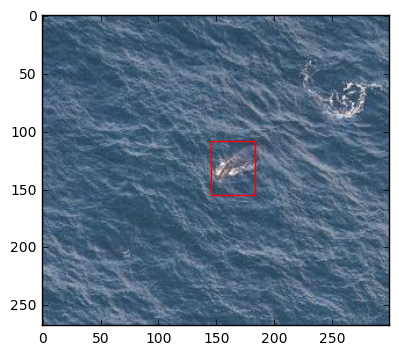

In [125]:
check_smaller(val_files[:50], p, 'valid')

In [104]:
def get_lm():
    return Sequential([
            Flatten(input_shape=(512,9,8)),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.),
            Dense(4, activation='linear')
        ])

In [105]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [106]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 18s - loss: 40.0534 - acc: 0.9197 - val_loss: 162.5064 - val_acc: 0.8842
Epoch 2/25
3862/3862 [==============================] - 18s - loss: 36.4569 - acc: 0.9389 - val_loss: 162.5920 - val_acc: 0.8886
Epoch 3/25
3862/3862 [==============================] - 18s - loss: 40.1754 - acc: 0.9296 - val_loss: 164.1653 - val_acc: 0.8827
Epoch 4/25
3862/3862 [==============================] - 18s - loss: 40.4975 - acc: 0.9213 - val_loss: 163.3354 - val_acc: 0.8900
Epoch 5/25
3862/3862 [==============================] - 18s - loss: 37.5219 - acc: 0.9298 - val_loss: 163.8648 - val_acc: 0.8812
Epoch 6/25
3862/3862 [==============================] - 18s - loss: 36.8682 - acc: 0.9340 - val_loss: 163.7962 - val_acc: 0.8886
Epoch 7/25
3862/3862 [==============================] - 18s - loss: 37.4504 - acc: 0.9280 - val_loss: 164.2201 - val_acc: 0.8871
Epoch 8/25
1920/3862 [=============>..............

KeyboardInterrupt: 

In [102]:
lm.compile(Adam(lr=0.0001), loss='mean_squared_error', metrics=['accuracy'])

In [103]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 18s - loss: 36.4769 - acc: 0.9363 - val_loss: 162.4283 - val_acc: 0.8842
Epoch 2/25
3862/3862 [==============================] - 18s - loss: 35.7335 - acc: 0.9278 - val_loss: 162.2397 - val_acc: 0.8827
Epoch 3/25
3862/3862 [==============================] - 18s - loss: 38.2445 - acc: 0.9239 - val_loss: 162.3874 - val_acc: 0.8827
Epoch 4/25
3862/3862 [==============================] - 18s - loss: 38.2471 - acc: 0.9296 - val_loss: 162.3046 - val_acc: 0.8842
Epoch 5/25
2144/3862 [===============>..............] - ETA: 7s - loss: 39.2802 - acc: 0.9160

KeyboardInterrupt: 

In [69]:
p = lm.predict(val_f[:50, :,:,:])

44
w_647.jpg


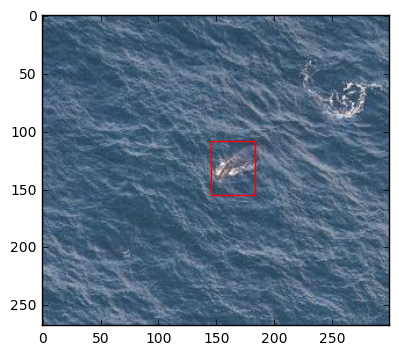

In [125]:
check_smaller(val_files[:50], p, 'valid')

## Same Loss, Sequential

In [106]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(4, name='x')(x)


In [107]:
model = Model([inp], [x])

In [108]:
model.compile(Adam(lr=0.001), loss='mse', metrics=['accuracy'])

In [109]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 8075.7893 - acc: 0.5259 - val_loss: 6298.7298 - val_acc: 0.6290
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 4436.4621 - acc: 0.6372 - val_loss: 2070.8757 - val_acc: 0.6716
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 1073.1863 - acc: 0.7791 - val_loss: 406.7911 - val_acc: 0.8182


In [110]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 267.3454 - acc: 0.8628 - val_loss: 210.2154 - val_acc: 0.8754
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 176.6705 - acc: 0.8866 - val_loss: 194.1105 - val_acc: 0.8680
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 164.0516 - acc: 0.8858 - val_loss: 183.3262 - val_acc: 0.8798


In [111]:
model.optimizer.lr = 0.0001

In [112]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 147.0374 - acc: 0.8912 - val_loss: 185.4268 - val_acc: 0.8842
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 142.2813 - acc: 0.8993 - val_loss: 177.6610 - val_acc: 0.8768
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 136.3232 - acc: 0.9042 - val_loss: 178.2565 - val_acc: 0.8710


In [113]:
model.save_weights('bb_reg_177.h5')

In [114]:
model.optimizer.lr = 0.00001

In [118]:
model.fit?

In [115]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 124.8658 - acc: 0.9065 - val_loss: 183.4937 - val_acc: 0.8666
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 125.4048 - acc: 0.8990 - val_loss: 185.4804 - val_acc: 0.8724
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 122.9679 - acc: 0.8990 - val_loss: 180.3356 - val_acc: 0.8768


In [116]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 110.3213 - acc: 0.9032 - val_loss: 181.9005 - val_acc: 0.8871
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 109.0549 - acc: 0.8985 - val_loss: 177.7175 - val_acc: 0.8798
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 106.9531 - acc: 0.9050 - val_loss: 175.2077 - val_acc: 0.8886


In [117]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 106.9224 - acc: 0.9034 - val_loss: 175.8631 - val_acc: 0.8812
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 95.1023 - acc: 0.9112 - val_loss: 176.0228 - val_acc: 0.8812
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 96.4693 - acc: 0.9029 - val_loss: 173.4289 - val_acc: 0.8842


In [119]:
model.optimizer.lr = 0.000001

In [120]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 93.0890 - acc: 0.9065 - val_loss: 172.5970 - val_acc: 0.8856
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 90.3780 - acc: 0.9179 - val_loss: 176.6691 - val_acc: 0.8768
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 89.7958 - acc: 0.9143 - val_loss: 174.9496 - val_acc: 0.8768


In [121]:
model.save_weights('bb_reg_174.h5')

In [132]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(4, name='x')(x)


In [133]:
model = Model([inp], [x])

In [134]:
model.compile(Adam(lr=0.001), loss='mse', metrics=['accuracy'])

In [135]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 8s - loss: 6867.6492 - acc: 0.5707 - val_loss: 3771.6487 - val_acc: 0.6202
Epoch 2/3
3862/3862 [==============================] - 8s - loss: 971.8353 - acc: 0.8110 - val_loss: 453.4316 - val_acc: 0.8519
Epoch 3/3
3862/3862 [==============================] - 8s - loss: 203.6815 - acc: 0.8871 - val_loss: 217.3524 - val_acc: 0.8842


In [137]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 9s - loss: 122.3896 - acc: 0.9008 - val_loss: 187.2342 - val_acc: 0.8842
Epoch 2/3
3862/3862 [==============================] - 9s - loss: 115.9352 - acc: 0.9055 - val_loss: 187.7837 - val_acc: 0.8827
Epoch 3/3
3862/3862 [==============================] - 8s - loss: 111.6772 - acc: 0.8988 - val_loss: 185.2345 - val_acc: 0.8827


In [126]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 331.0831 - acc: 0.8661 - val_loss: 303.8928 - val_acc: 0.8490
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 220.6478 - acc: 0.8760 - val_loss: 230.7797 - val_acc: 0.8710
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 197.9277 - acc: 0.8819 - val_loss: 216.4085 - val_acc: 0.8710


In [127]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 173.7272 - acc: 0.8843 - val_loss: 214.0767 - val_acc: 0.8754
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 161.0424 - acc: 0.8941 - val_loss: 211.9821 - val_acc: 0.8856
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 146.2254 - acc: 0.8967 - val_loss: 209.4020 - val_acc: 0.8856


In [128]:
model.optimizer.lr *= 0.1

In [129]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 142.7569 - acc: 0.8907 - val_loss: 204.7074 - val_acc: 0.8871
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 133.0113 - acc: 0.8920 - val_loss: 198.7938 - val_acc: 0.8871
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 128.8049 - acc: 0.8944 - val_loss: 201.6810 - val_acc: 0.8886


In [130]:
model.optimizer.lr *= 0.1

In [131]:
model.fit(tr_f, tr_y, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 120.1811 - acc: 0.9003 - val_loss: 197.5577 - val_acc: 0.8842
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 110.4885 - acc: 0.8988 - val_loss: 205.8629 - val_acc: 0.8827
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 103.4909 - acc: 0.9021 - val_loss: 198.6278 - val_acc: 0.8900


# Diff loss for xy, wh

In [17]:
tr_y_wh = tr_y[:, :2]
tr_y_xy = tr_y[:, 2:]
val_y_wh = val_y[:, :2]
val_y_xy = val_y[:, 2:]

In [130]:
tr_y_wh.shape

(3862, 2)

In [97]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x_xy = Dense(2, name='xy')(x)
x_wh = Dense(2,  name='wh')(x)

In [98]:
batch_size = 32

In [99]:
model = Model([inp], [x_xy, x_wh])
model.compile(Adam(lr=0.001), loss=['mse', 'mse'], metrics=['accuracy'],
             loss_weights=[1., .5])

model.fit(tr_f, [tr_y_xy, tr_y_wh], batch_size=batch_size, nb_epoch=3, shuffle=True,validation_data=(val_f, [val_y_xy, val_y_wh]))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 14465.4923 - xy_loss: 12761.7886 - wh_loss: 3407.4076 - xy_acc: 0.7613 - wh_acc: 0.5725 - val_loss: 10551.8931 - val_xy_loss: 9349.5669 - val_wh_loss: 2404.6527 - val_xy_acc: 0.8226 - val_wh_acc: 0.6613
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 8171.4488 - xy_loss: 7413.9171 - wh_loss: 1515.0634 - xy_acc: 0.8421 - wh_acc: 0.6538 - val_loss: 3795.0837 - val_xy_loss: 3635.9467 - val_wh_loss: 318.2742 - val_xy_acc: 0.8387 - val_wh_acc: 0.8182
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 1938.7510 - xy_loss: 1827.0054 - wh_loss: 223.4912 - xy_acc: 0.8752 - wh_acc: 0.8291 - val_loss: 561.1698 - val_xy_loss: 490.4514 - val_wh_loss: 141.4368 - val_xy_acc: 0.8666 - val_wh_acc: 0.8548


In [100]:

model.fit(tr_f, [tr_y_xy, tr_y_wh], batch_size=batch_size, nb_epoch=3, shuffle=True,validation_data=(val_f, [val_y_xy, val_y_wh]))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 444.8078 - xy_loss: 373.6556 - wh_loss: 142.3043 - xy_acc: 0.8915 - wh_acc: 0.8503 - val_loss: 340.1504 - val_xy_loss: 269.9392 - val_wh_loss: 140.4225 - val_xy_acc: 0.8915 - val_wh_acc: 0.8519
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 303.7407 - xy_loss: 239.6533 - wh_loss: 128.1749 - xy_acc: 0.9081 - wh_acc: 0.8509 - val_loss: 311.3540 - val_xy_loss: 245.6788 - val_wh_loss: 131.3504 - val_xy_acc: 0.8798 - val_wh_acc: 0.8578
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 284.9300 - xy_loss: 225.0417 - wh_loss: 119.7767 - xy_acc: 0.8982 - wh_acc: 0.8485 - val_loss: 310.4299 - val_xy_loss: 245.3683 - val_wh_loss: 130.1233 - val_xy_acc: 0.8724 - val_wh_acc: 0.8534


In [101]:

model.fit(tr_f, [tr_y_xy, tr_y_wh], batch_size=batch_size, nb_epoch=3, shuffle=True,validation_data=(val_f, [val_y_xy, val_y_wh]))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 270.6701 - xy_loss: 213.0381 - wh_loss: 115.2640 - xy_acc: 0.9052 - wh_acc: 0.8449 - val_loss: 312.5376 - val_xy_loss: 247.2343 - val_wh_loss: 130.6066 - val_xy_acc: 0.8886 - val_wh_acc: 0.8504
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 242.6286 - xy_loss: 189.2519 - wh_loss: 106.7533 - xy_acc: 0.9104 - wh_acc: 0.8488 - val_loss: 296.8203 - val_xy_loss: 232.7069 - val_wh_loss: 128.2268 - val_xy_acc: 0.8856 - val_wh_acc: 0.8534
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 225.3158 - xy_loss: 176.3549 - wh_loss: 97.9219 - xy_acc: 0.9104 - wh_acc: 0.8477 - val_loss: 288.3907 - val_xy_loss: 225.6929 - val_wh_loss: 125.3956 - val_xy_acc: 0.8930 - val_wh_acc: 0.8534


In [102]:

model.fit(tr_f, [tr_y_xy, tr_y_wh], batch_size=batch_size, nb_epoch=3, shuffle=True,validation_data=(val_f, [val_y_xy, val_y_wh]))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 214.5164 - xy_loss: 166.9793 - wh_loss: 95.0743 - xy_acc: 0.9143 - wh_acc: 0.8465 - val_loss: 285.7201 - val_xy_loss: 223.0757 - val_wh_loss: 125.2889 - val_xy_acc: 0.8944 - val_wh_acc: 0.8490
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 216.2199 - xy_loss: 170.2896 - wh_loss: 91.8607 - xy_acc: 0.9102 - wh_acc: 0.8509 - val_loss: 303.7773 - val_xy_loss: 241.8552 - val_wh_loss: 123.8442 - val_xy_acc: 0.8842 - val_wh_acc: 0.8475
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 207.5793 - xy_loss: 163.0254 - wh_loss: 89.1077 - xy_acc: 0.9130 - wh_acc: 0.8532 - val_loss: 292.3895 - val_xy_loss: 231.6699 - val_wh_loss: 121.4393 - val_xy_acc: 0.8812 - val_wh_acc: 0.8490


In [54]:
model.fit(tr_f, [tr_y_xy, tr_y_wh], batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, [val_y_xy, val_y_wh]))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 271.4275 - xy_loss: 196.4410 - wh_loss: 99.9819 - xy_acc: 0.9130 - wh_acc: 0.8436 - val_loss: 340.4479 - val_xy_loss: 247.2966 - val_wh_loss: 124.2017 - val_xy_acc: 0.8827 - val_wh_acc: 0.8622
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 264.7400 - xy_loss: 194.8491 - wh_loss: 93.1877 - xy_acc: 0.9042 - wh_acc: 0.8467 - val_loss: 336.3752 - val_xy_loss: 246.0424 - val_wh_loss: 120.4438 - val_xy_acc: 0.8871 - val_wh_acc: 0.8534
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 261.3090 - xy_loss: 193.2293 - wh_loss: 90.7730 - xy_acc: 0.9055 - wh_acc: 0.8516 - val_loss: 332.4244 - val_xy_loss: 239.6825 - val_wh_loss: 123.6559 - val_xy_acc: 0.8783 - val_wh_acc: 0.8519


In [60]:
model.fit(tr_f, [tr_y_xy, tr_y_wh], batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, [val_y_xy, val_y_wh]))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 260.8134 - xy_loss: 206.6932 - wh_loss: 108.2403 - xy_acc: 0.9192 - wh_acc: 0.8516 - val_loss: 311.0272 - val_xy_loss: 249.9726 - val_wh_loss: 122.1092 - val_xy_acc: 0.8856 - val_wh_acc: 0.8519
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 236.3235 - xy_loss: 184.3646 - wh_loss: 103.9177 - xy_acc: 0.9130 - wh_acc: 0.8493 - val_loss: 295.3814 - val_xy_loss: 233.0120 - val_wh_loss: 124.7388 - val_xy_acc: 0.8827 - val_wh_acc: 0.8504
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 231.2743 - xy_loss: 181.6605 - wh_loss: 99.2277 - xy_acc: 0.9171 - wh_acc: 0.8472 - val_loss: 295.1011 - val_xy_loss: 234.5699 - val_wh_loss: 121.0623 - val_xy_acc: 0.8812 - val_wh_acc: 0.8534


In [61]:
p_xy, p_wh = model.predict(val_f)

In [75]:
p_all = np.hstack((p_wh, p_xy))

61
w_1824.jpg


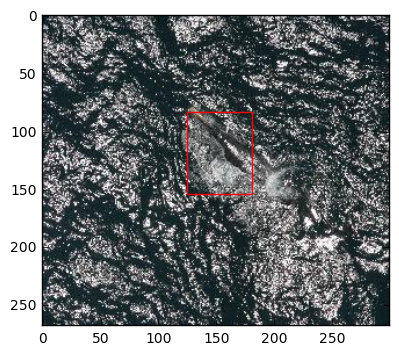

In [84]:
check_smaller(val_files, p_all, 'valid')

In [253]:
model.save_weights('bb_reg_multi_loss_220.h5')

# Diff Model for xy, wh

In [18]:
tr_y_wh.shape

(3862, 2)

In [20]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(2,  name='wh')(x)

In [21]:
batch_size = 32

In [28]:
model = Model([inp], [x])
model.compile(Adam(lr=0.001), loss=['mse'], metrics=['accuracy'])

model.fit(tr_f, tr_y_wh, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_wh))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 79.8562 - acc: 0.8498 - val_loss: 123.1030 - val_acc: 0.8578
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 71.3931 - acc: 0.8524 - val_loss: 122.1006 - val_acc: 0.8622
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 68.5846 - acc: 0.8555 - val_loss: 120.6607 - val_acc: 0.8519


In [29]:
model.fit(tr_f, tr_y_wh, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_wh))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 64.5332 - acc: 0.8604 - val_loss: 123.1322 - val_acc: 0.8548
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 58.4518 - acc: 0.8612 - val_loss: 126.2249 - val_acc: 0.8592
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 52.7876 - acc: 0.8630 - val_loss: 128.0395 - val_acc: 0.8651


In [30]:
model.optimizer.lr = 0.0001

In [31]:
model.fit(tr_f, tr_y_wh, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_wh))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 49.4181 - acc: 0.8692 - val_loss: 124.9445 - val_acc: 0.8592
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 47.8491 - acc: 0.8656 - val_loss: 121.9406 - val_acc: 0.8519
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 46.3595 - acc: 0.8799 - val_loss: 123.0923 - val_acc: 0.8534


In [32]:
model.optimizer.lr = 0.00001

In [33]:
model.fit(tr_f, tr_y_wh, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_wh))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 44.1952 - acc: 0.8793 - val_loss: 119.9771 - val_acc: 0.8563
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 41.4017 - acc: 0.8796 - val_loss: 118.0581 - val_acc: 0.8534
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 40.4277 - acc: 0.8871 - val_loss: 121.8485 - val_acc: 0.8504


In [34]:
val_wh = model.predict(val_f)

### XY model

In [42]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(2,  name='xy')(x)

In [43]:
batch_size = 32

In [44]:
model = Model([inp], [x])
model.compile(Adam(lr=0.001), loss=['mse'], metrics=['accuracy'])

model.fit(tr_f, tr_y_xy, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_xy))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 13029.6182 - acc: 0.7025 - val_loss: 10802.4264 - val_acc: 0.7845
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 7823.7116 - acc: 0.8097 - val_loss: 4434.5960 - val_acc: 0.8314
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 2144.5405 - acc: 0.8379 - val_loss: 642.6153 - val_acc: 0.8724


In [45]:
model.fit(tr_f, tr_y_xy, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_xy))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 570.3388 - acc: 0.8558 - val_loss: 355.7758 - val_acc: 0.8783
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 414.7619 - acc: 0.8625 - val_loss: 323.1373 - val_acc: 0.8944
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 383.3125 - acc: 0.8687 - val_loss: 287.6480 - val_acc: 0.8871


In [46]:
model.fit(tr_f, tr_y_xy, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_xy))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 365.2336 - acc: 0.8698 - val_loss: 282.9775 - val_acc: 0.8930
Epoch 2/3
3862/3862 [==============================] - 3s - loss: 341.5185 - acc: 0.8767 - val_loss: 264.8041 - val_acc: 0.8988
Epoch 3/3
3862/3862 [==============================] - 3s - loss: 331.6163 - acc: 0.8695 - val_loss: 261.7037 - val_acc: 0.8944


In [47]:
model.fit(tr_f, tr_y_xy, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_xy))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 3s - loss: 317.2015 - acc: 0.8742 - val_loss: 253.3243 - val_acc: 0.8988
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 300.1251 - acc: 0.8793 - val_loss: 256.9763 - val_acc: 0.9003
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 301.1117 - acc: 0.8744 - val_loss: 251.0099 - val_acc: 0.9047


In [48]:
model.optimizer.lr = 0.0001

In [49]:
model.fit(tr_f, tr_y_xy, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_f, val_y_xy))

Train on 3862 samples, validate on 682 samples
Epoch 1/3
3862/3862 [==============================] - 2s - loss: 282.7782 - acc: 0.8775 - val_loss: 252.9452 - val_acc: 0.8915
Epoch 2/3
3862/3862 [==============================] - 2s - loss: 274.4771 - acc: 0.8824 - val_loss: 247.6036 - val_acc: 0.9003
Epoch 3/3
3862/3862 [==============================] - 2s - loss: 264.8941 - acc: 0.8804 - val_loss: 247.1380 - val_acc: 0.8959


# Make Predictions

In [140]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(4, name='x')(x)


In [141]:
model = Model([inp], [x])

In [142]:
model.compile(Adam(lr=0.001), loss='mse', metrics=['accuracy'])

In [143]:
model.load_weights('bb_reg_174.h5')

In [255]:
pr = model.predict(val_f)

71
w_1622.jpg


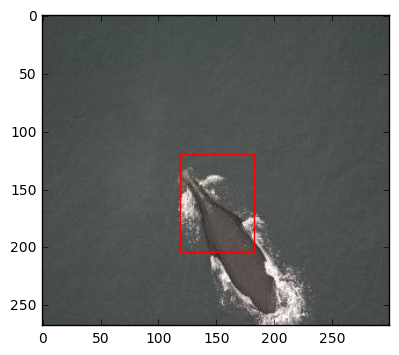

In [253]:
check_smaller(val_files, pr, 'valid')

In [218]:
pr.shape

(682, 4)

In [219]:
pr[0]

array([  59.1   ,   67.6058,  147.0534,   92.4912], dtype=float32)

In [256]:
pr[:, 0] = pr[:,0] * 1.25

In [257]:
pr[:, 1] = pr[:,1] * 1.25

210
w_7777.jpg


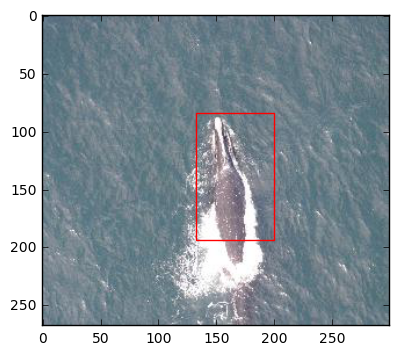

In [293]:
check_smaller(val_files, pr, 'valid')

In [296]:
test_b = ImageDataGenerator().flow_from_directory(input_dir+'/test',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 6925 images belonging to 1 classes.


In [297]:
test_files = test_b.filenames

In [298]:
test_data = np.concatenate([test_b.next() for i in range(test_b.nb_sample)])

In [299]:
test_data.shape

(6925, 3, 300, 268)

In [300]:
vgg = Vgg16BN(size=target_size, include_top=False)

In [301]:
model = vgg.model

In [302]:
for l  in model.layers: l.trainable = False

In [303]:
test_conv_f = model.predict(test_data)

In [304]:
test_conv_f.shape

(6925, 512, 9, 8)

In [305]:
save_array('vggbb_300_268_test_conv_feat.bc', test_conv_f)

In [306]:
inp = Input((512,9,8))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(4, name='x')(x)


In [307]:
model = Model([inp], [x])

In [308]:
model.compile(Adam(lr=0.001), loss='mse', metrics=['accuracy'])

In [309]:
model.load_weights('bb_reg_174.h5')

In [310]:
test_p = model.predict(test_conv_f)

In [314]:
test_files = [f[f.find('/') + 1:] for f in test_files]

In [318]:
test_data =np.hstack((np.array(test_files)[:, np.newaxis], test_p))

In [320]:
testdf = pd.DataFrame(test_data, columns=['Image', 'w', 'h', 'x', 'y'])

In [321]:
testdf.head()

,Image,w,h,x,y
0,w_8037.jpg,46.8530311584,70.0880508423,115.171180725,116.515335083
1,w_4494.jpg,49.7281532288,69.5869827271,114.272483826,62.9298095703
2,w_4673.jpg,57.4515991211,58.6202926636,117.568328857,115.96710968
3,w_8273.jpg,57.7088088989,62.8645629883,130.98928833,75.4465560913
4,w_7611.jpg,48.8724060059,67.3129196167,150.144607544,104.484199524


3324
w_9631.jpg


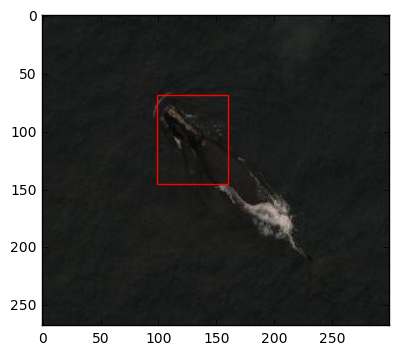

In [356]:
check_smaller(testdf.Image.values, testdf[['w', 'h', 'x', 'y']].values, 'test/unknown')

In [357]:
len(testdf)

6925

In [359]:
testdf.to_csv('test_bb_ann_300_268.csv', index=False)